# Kaggle's Titanic Competition
This notebook is my first solution o the [Titanic - Machine Learning from Disaster Competition ](https://www.kaggle.com/c/titanic/).

## Setup

In [34]:
from google.colab import files

import numpy as np
import pandas as pd

### Loading Data

In [35]:
uploaded = files.upload()
print("Setup Complete")

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
Setup Complete


# Data Exploration


### Features

In [36]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Initial Modifications

In [37]:
df_train = df_train.drop('PassengerId', axis=1)
#df_test = df_test.drop('PassengerId', axis=1)

In [38]:
all_data = [df_train, df_test]
for data in all_data :
    data['Status'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [39]:
df_train.Status.unique()
for dataset in all_data:
    dataset['Status'] = dataset['Status'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Status'] = dataset['Status'].replace('Mlle', 'Miss')
    dataset['Status'] = dataset['Status'].replace('Ms', 'Miss')
    dataset['Status'] = dataset['Status'].replace('Mme', 'Mrs')

### Handling Missing Values


In [40]:
total  = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Status,0,0.000000
Fare,0,0.000000
Ticket,0,0.000000


In [41]:
total  = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Status,0,0.000000
Embarked,0,0.000000
Ticket,0,0.000000


#### Embarked

In [42]:
df_train['Embarked'].fillna('S', inplace = True)
df_test['Embarked'].fillna('S', inplace = True)

#### Fare

In [43]:
df_train['Fare'].fillna(df_train['Fare'].mean(), inplace = True)
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace = True)

#### Cabin

In [44]:
df_train.Cabin.fillna('None', inplace=True)
df_test.Cabin.fillna('None', inplace=True)

#### Age


In [45]:
df_train["Age"].fillna(df_train.groupby("Status")["Age"].transform("median"), inplace=True)
df_test["Age"].fillna(df_test.groupby("Status")["Age"].transform("median"), inplace=True)

### Vasualizations and Feature Engineering


In [46]:
def bar_chart(feature):
  survived = df_train[df_train.Survived == 1][feature].value_counts()
  dead = df_train[df_train.Survived == 0][feature].value_counts()
  df = pd.DataFrame([survived,dead])
  df.index = ['Survived','Dead']
  df.plot(kind='bar', stacked=True, figsize=(10,5), title=feature)

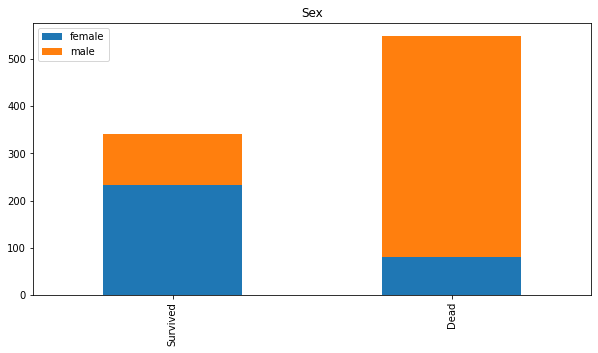

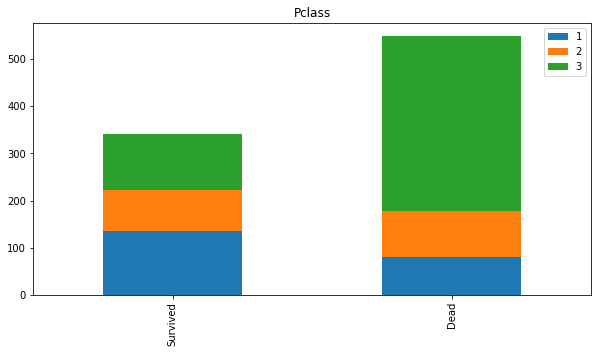

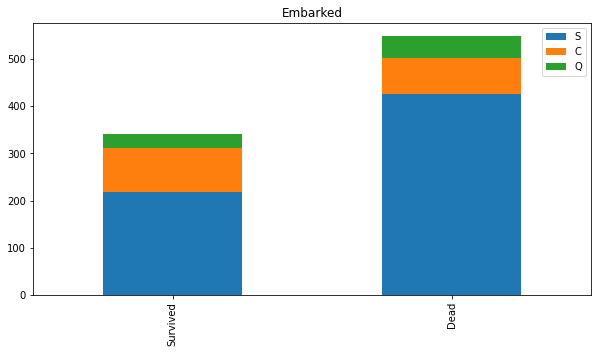

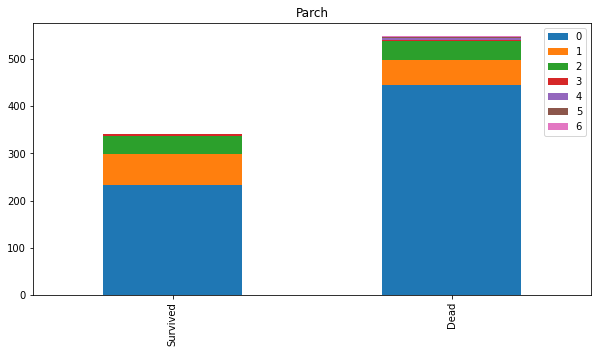

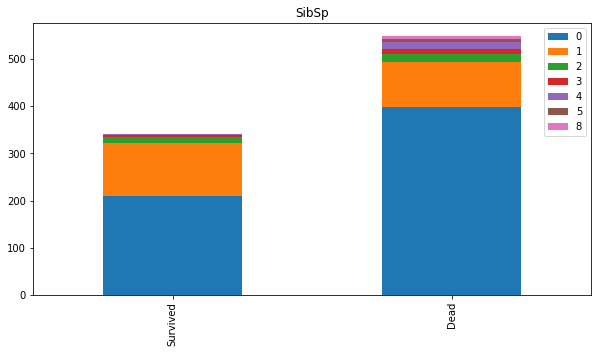

In [47]:
bar_chart('Sex')
bar_chart('Pclass')
bar_chart('Embarked')
bar_chart('Parch')
bar_chart('SibSp')

#### Family Size

In [48]:
for dataset in all_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

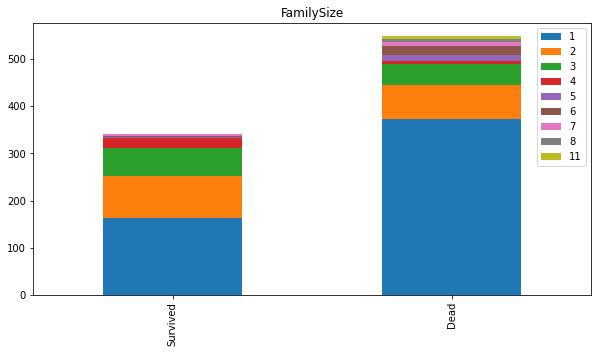

In [49]:
bar_chart('FamilySize')

#### Encoding Cathegorical Variables

In [50]:
sex_mapping = {"male": 0, "female": 1}
for dataset in all_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
    
for dataset in all_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [51]:
df_train.Cabin.unique()
for dataset in all_data:
  dataset['Cabin_category'] = dataset['Cabin'].astype(str).str[0]
  dataset['Cabin_category'] = dataset['Cabin_category'].map({'N':0,'A':1,'B':2,'C':2,'D':3,'E':4,'F':5,'G':6,'T':7})
  dataset['HasCabin'] = dataset['Cabin'].apply(lambda x:0 if x is np.nan else 1)

# Modeling and Training

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier

y_full = df_train["Survived"]

features = ["Pclass","Sex", "Age","IsAlone", "FamilySize", "Status","Embarked","Fare","Cabin_category","HasCabin"] 
X_full = pd.get_dummies(df_train[features])
X_test_full = pd.get_dummies(df_test[features])

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2,random_state=0)

X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)

model = RandomForestClassifier(max_depth=3, random_state=3)

model.fit(X_train, y_train)
val_predictions = model.predict(X_valid)

accuracy = accuracy_score(val_predictions,y_valid)

In [54]:
accuracy

0.8324022346368715

In [55]:
predictions = model.predict(X_test_full)

In [56]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)